In [8]:
# Helper Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from scipy.special import softmax
# Machine learning related libraries:
import torch
import torch.nn as nn            # base class used to develop all neural network models
import torch.nn.functional as F  # module of relu activation functions
import torch.optim as optim      # module of Adam optimizer
import glob
# from itertools import chain      # append two range() functions
from torch.utils.data import DataLoader # easy and organized data loading to the ML model
from torch.utils.data import Dataset #for nice loadable dataset creation

In [9]:
####### Detect if running on the clusters  #######
# use CUDA:
torch.cuda.is_available()
print("Is cuda available?", torch.cuda.is_available())

# set a flag
device = torch.device("cuda:0")

if torch.cuda.is_available():
    device = torch.device("cuda:2")  # you can continue going on here, like cuda:1 cuda:2....etc.
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Is cuda available? False
Running on the CPU


In [21]:
with open('mlqe_2023_edx/week3/dataset/csds.npy', 'rb') as f:
    data_noisy = np.load(f)

with open('mlqe_2023_edx/week3/dataset/csds_noiseless.npy', 'rb') as f:
    data = np.load(f)

with open('mlqe_2023_edx/week3/dataset/labels.npy', 'rb') as f:
    labels = np.load(f)

# selecting certain portion of the data
# max is 2000. data is 2000 images of cs diagrams each data entry is one image
print(len(data))
# here we select the first 200 images
portion = 200
data_noisy = data_noisy[:portion]
data = data[:portion]
lables = labels[:portion]

2000


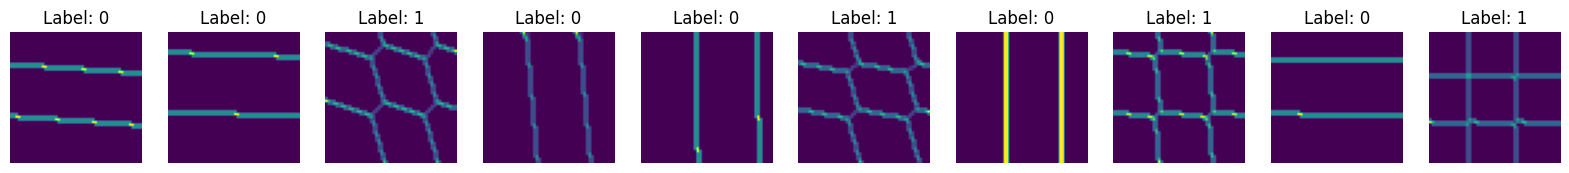

In [11]:
fig, ax = plt.subplots(1, 10, figsize=(20,10))
# we will look at the 10 images
a
# select a random set of 10 images to view
for index, d in enumerate(data[np.random.choice(len(data),size=10)]):
    ax[index].imshow(data[index])
    ax[index].axis('off')
    ax[index].set_title(f'Label: {(lables[index])}')
plt.show()
plt.close()
    

In [4]:
# we need to make this data readable for Pytorch
# Here we create a class of readable data sets and use the torch libraries to convert data
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.Tensor(data)
        self.labels = torch.Tensor(labels)
    # allows us to call the length of the data set object that we create using dataset.__len__()
    def __len__(self):
        return len(self.data)

    # allows us to call a specific item of the dataset from the dataset objec that we create
    def __getitem__(self,idx):
        data_idx = self.data[idx]
        label = self.labels[idx].type(torch.LongTensor)
        return data_idx, label

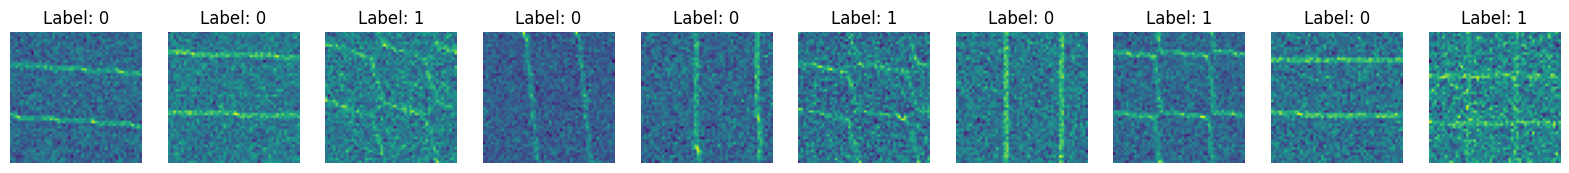

In [6]:
fig, ax = plt.subplots(1, 10, figsize=(20,10))
# we will look at the 10 noisy images

# select a random set of 10 images to view
for index, d in enumerate(data[np.random.choice(len(data),size=10)]):
    ax[index].imshow(data_noisy[index])
    ax[index].axis('off')
    ax[index].set_title(f'Label: {(lables[index])}')
plt.show()
plt.close()

In [7]:
dataset = CustomDataset(data, labels)

# this makes a training set of 80% of our data and 20% for testing
trainset, testset = torch.utils.data.random_split(dataset, (int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)))

# DataLoader prepares our data into batches to feed to the model. We input data not all at once but in batches. Dataloader can also shuffle data etc
batch_size = 8
trainloader = DataLoader(trainset, batch_size = batch_size)
testloader = DataLoader(testset, batch_size = batch_size)

In [8]:

noisyset = CustomDataset(data_noisy, labels)
# this makes a training set of 80% of our data and 20% for testing
trainset, testset = torch.utils.data.random_split(noisyset, (int(len(noisyset)*0.8), len(noisyset)-int(len(noisyset)*0.8)))

# DataLoader prepares our data into batches to feed to the model. We input data not all at once but in batches. Dataloader can also shuffle data etc
batch_size = 8
noisytrainloader = DataLoader(trainset, batch_size = batch_size)
noisytestloader = DataLoader(testset, batch_size = batch_size)

In [9]:
# our data is now in batches of 8

for X, y in trainloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(y)
    print(X)
    break

Shape of X: torch.Size([8, 50, 50])
Shape of y: torch.Size([8]) torch.int64
tensor([0, 0, 1, 1, 0, 0, 0, 1])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.00

In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# defines our neural network class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()

        # converts the 2D data into a 1D list for input to the network
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            # linear transformation with input size 50x50 with output of 16 (16 nodes in first layer)
            nn.Linear(50*50,16),
            # use the ReLU activation function
            nn.ReLU(),
            # then applies linear transformation on the 16 nodes to a binary output (prob of 1, prob of 0) in terms of quantum dots active
            nn.Linear(16,2),
        )

    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# here we initialize an instance of the class
model = NeuralNetwork().to(device)
# print the status of the model
# the print command is inherited from nn.Module in the definition of the network
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2500, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [11]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {pytorch_total_params}")

Trainable params: 40050


In [12]:
# at this point the model is set up, it just needs training, for this we must define a loss function and an optimizer

In [13]:
# optimizing the model parameters
# to train the model we need a LOSS FUNCTION and an OPTIMIZER

loss_fn = nn.CrossEntropyLoss() # we use Cross Entropy as loss
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) # The optimizer is Adam

In [14]:
# define the train and test loss accumulation
train_loss_dnn = []
train_acc_dnn = []
test_loss_dnn = []
test_acc_dnn = []

In [15]:
# define the train and test loss accumulation
noisytrain_loss_dnn = []
noisytrain_acc_dnn = []
noisytest_loss_dnn = []
noisytest_acc_dnn = []

In [16]:
# define training function: make predicition on data set batch,
# backpropagate the error and adjust model parameters

def train(dataloader, model, loss_fn, optimizer, train_loss, train_acc):
    # dataloader will be a set of batched data 
    num_batches = len(dataloader)

    #size = num_batches * batch_size, total number of diagrams considered
    size = len(dataloader.dataset)
    model.train()
    running_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        #compute prediction error
        pred = model(X)
        loss = loss_fn(pred,y)

        #Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # collect the accuracy:
        running_loss += loss.item()
        correct += (pred.argmax(1)==y).type(torch.float).sum().item()

        if batch % 25==0:
            loss,current = loss.item(), batch*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    running_loss /= num_batches
    correct /= size

    train_acc.append(correct)
    train_loss.append(running_loss)

#check performance against the test data set
def test(dataloader,model,loss_fn,test_loss, test_acc):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    running_loss, correct = 0, 0
    with torch.no_grad():
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            pred = model(X)
            running_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    running_loss /= num_batches
    correct /= size

    test_acc.append(correct)
    test_loss.append(running_loss)
    print(f"Test Error: \n Accuracy {(100*correct):>0.1f}%, Avg loss:{running_loss:>8f}\n")

In [17]:
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n -------------------")
    train(trainloader,model,loss_fn,optimizer, train_loss_dnn, train_acc_dnn)
    test(testloader,model,loss_fn, test_loss_dnn, test_acc_dnn)
print("Done!")

Epoch 1
 -------------------
loss: 0.698434 [    0/  160]
Test Error: 
 Accuracy 55.0%, Avg loss:0.600137

Epoch 2
 -------------------
loss: 0.367192 [    0/  160]
Test Error: 
 Accuracy 72.5%, Avg loss:0.523607

Epoch 3
 -------------------
loss: 0.301127 [    0/  160]
Test Error: 
 Accuracy 85.0%, Avg loss:0.437104

Epoch 4
 -------------------
loss: 0.249698 [    0/  160]
Test Error: 
 Accuracy 92.5%, Avg loss:0.358158

Epoch 5
 -------------------
loss: 0.208643 [    0/  160]
Test Error: 
 Accuracy 92.5%, Avg loss:0.291293

Epoch 6
 -------------------
loss: 0.170755 [    0/  160]
Test Error: 
 Accuracy 92.5%, Avg loss:0.241879

Epoch 7
 -------------------
loss: 0.138296 [    0/  160]
Test Error: 
 Accuracy 92.5%, Avg loss:0.205211

Epoch 8
 -------------------
loss: 0.106234 [    0/  160]
Test Error: 
 Accuracy 95.0%, Avg loss:0.176056

Epoch 9
 -------------------
loss: 0.080870 [    0/  160]
Test Error: 
 Accuracy 95.0%, Avg loss:0.156961

Epoch 10
 -------------------
loss: 0

In [17]:
def create_acc_loss_graph(train_acc,train_loss, test_acc, test_loss):
    fig, axes = plt.subplots(ncols=2, nrows=1, dpi=300)
    fig.set_size_inches(9, 3)
    ax1, ax2 = axes[0], axes[1]

    ax1.plot(train_acc,'-o',label="train", markersize=4)
    ax1.plot(test_acc,'--+',label="test", markersize=4)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc=3)

    ax2.plot(train_loss,'-o',label="train", markersize=4)
    ax2.plot(test_loss,'--+',label=" test", markersize=4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc=1)

    #plot parameters
    ax1.set_ylim(0, np.max([np.max(train_acc),np.max(test_acc)])+0.1)
    ax2.set_ylim(-0.1, np.max([np.max(train_loss),np.max(test_loss)])+0.1)
    ax1.grid(True, which='both',linewidth=0.1)
    ax2.grid(True, which='both',linewidth=0.1)
    plt.tight_layout()
    plt.show()

In [18]:
epochs = 10

for t in range(epochs):
    print(f"Epoch {t+1}\n -------------------")
    train(noisytrainloader,model,loss_fn,optimizer, noisytrain_loss_dnn, noisytrain_acc_dnn)
    test(noisytestloader,model,loss_fn, noisytest_loss_dnn, noisytest_acc_dnn)
print("Done!")

Epoch 1
 -------------------
loss: 0.692225 [    0/  160]
Test Error: 
 Accuracy 47.5%, Avg loss:0.650433

Epoch 2
 -------------------
loss: 0.365192 [    0/  160]
Test Error: 
 Accuracy 55.0%, Avg loss:0.631511

Epoch 3
 -------------------
loss: 0.236653 [    0/  160]
Test Error: 
 Accuracy 70.0%, Avg loss:0.618556

Epoch 4
 -------------------
loss: 0.149929 [    0/  160]
Test Error: 
 Accuracy 70.0%, Avg loss:0.609593

Epoch 5
 -------------------
loss: 0.087949 [    0/  160]
Test Error: 
 Accuracy 72.5%, Avg loss:0.615934

Epoch 6
 -------------------
loss: 0.051663 [    0/  160]
Test Error: 
 Accuracy 75.0%, Avg loss:0.623820

Epoch 7
 -------------------
loss: 0.032768 [    0/  160]
Test Error: 
 Accuracy 75.0%, Avg loss:0.632329

Epoch 8
 -------------------
loss: 0.022159 [    0/  160]
Test Error: 
 Accuracy 77.5%, Avg loss:0.641459

Epoch 9
 -------------------
loss: 0.016060 [    0/  160]
Test Error: 
 Accuracy 77.5%, Avg loss:0.650661

Epoch 10
 -------------------
loss: 0

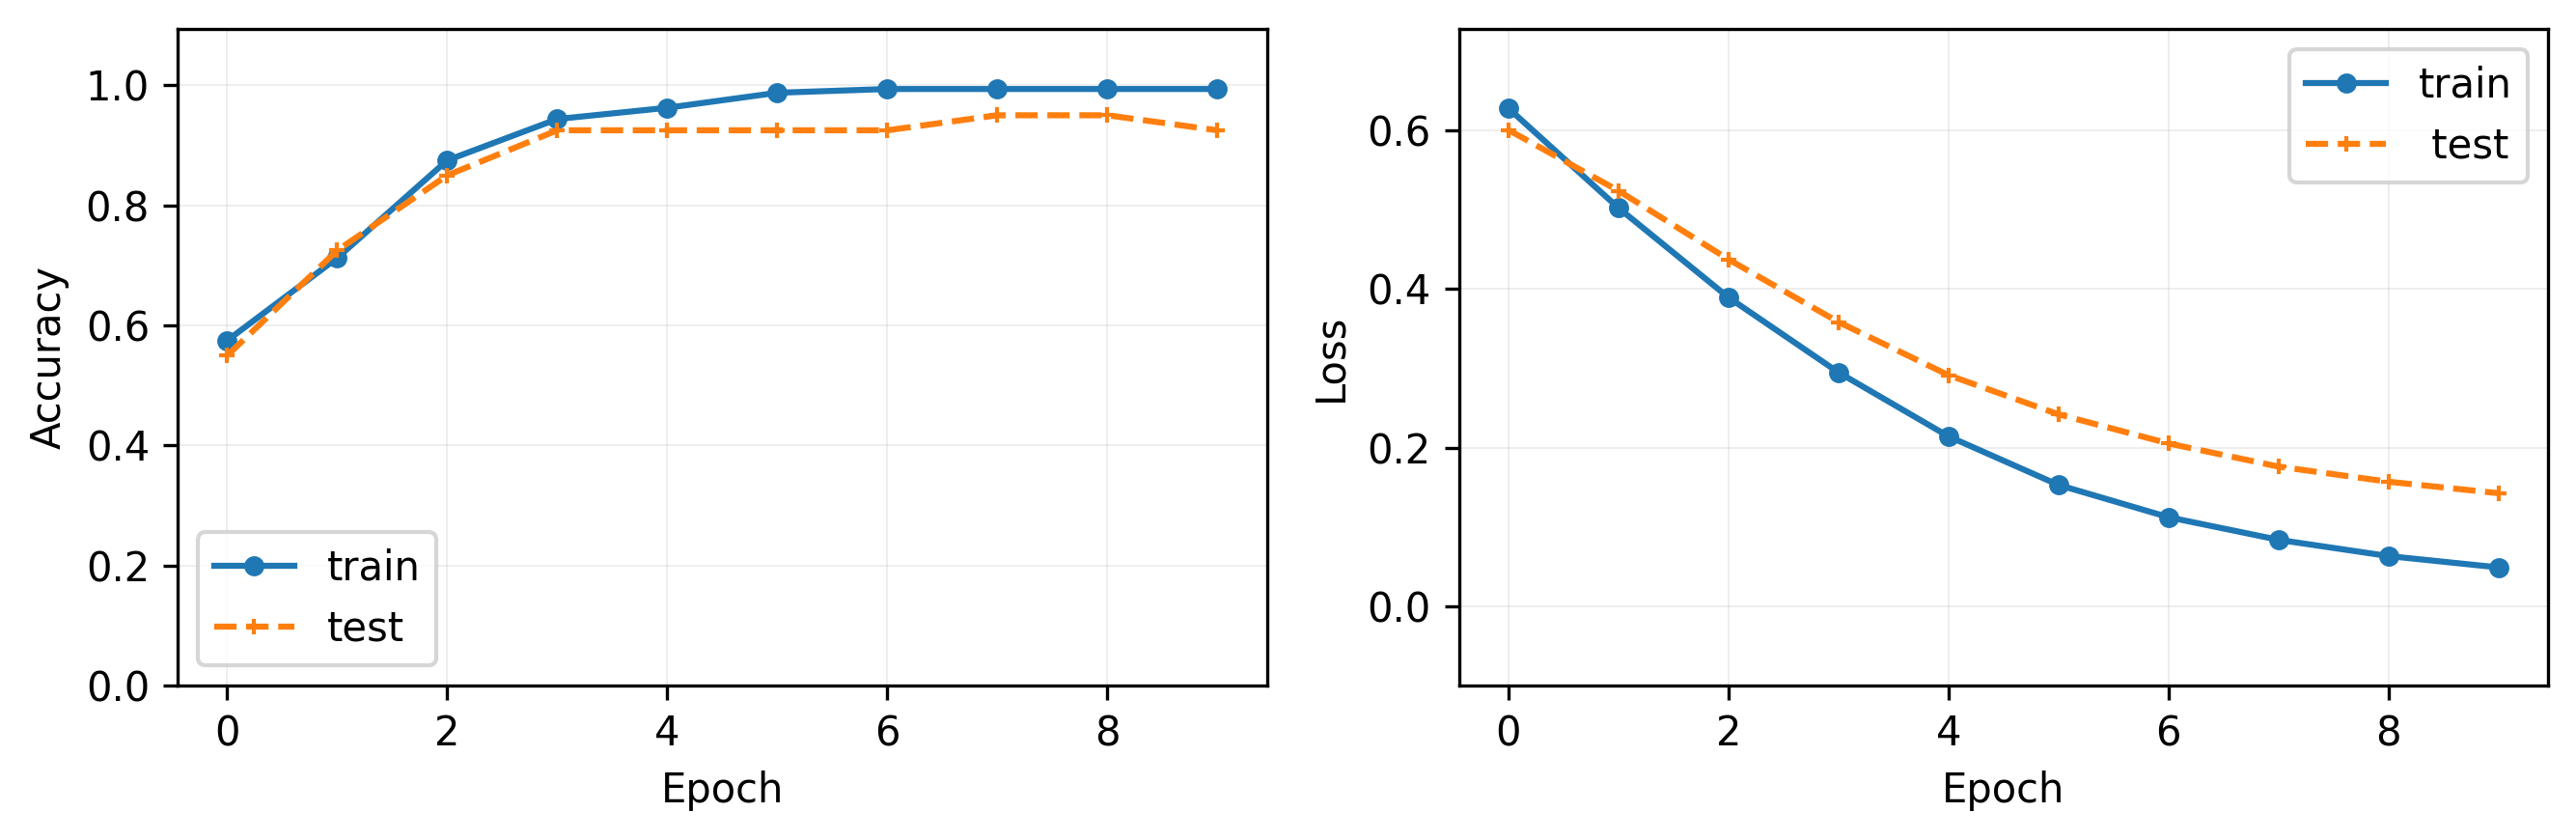

In [19]:
create_acc_loss_graph(train_acc_dnn,train_loss_dnn, test_acc_dnn, test_loss_dnn)


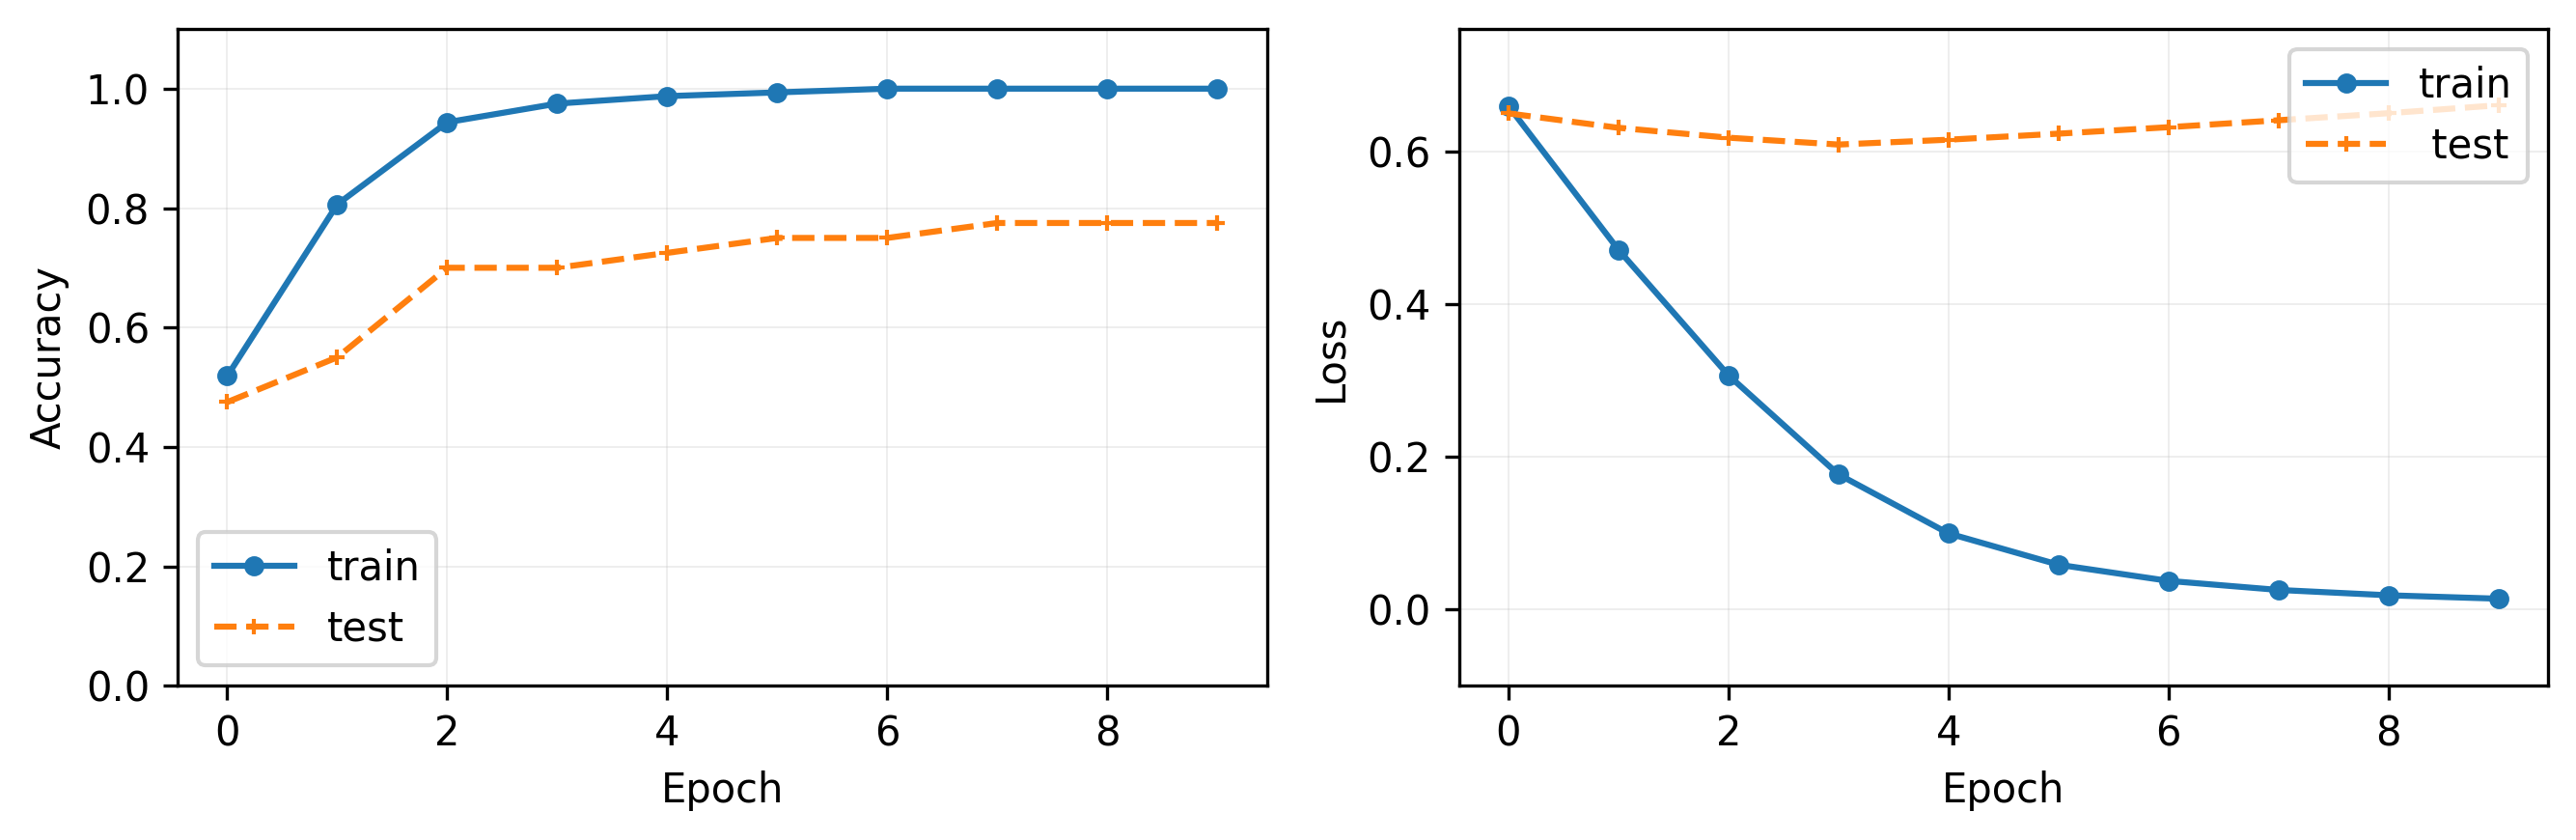

In [19]:
create_acc_loss_graph(noisytrain_acc_dnn,noisytrain_loss_dnn, noisytest_acc_dnn, noisytest_loss_dnn)

In [20]:
# now we will add in a convolution layer, the first model was a dense neural network in which we have all to all connectivity. 
# we reduce the complexity by using convolution

In [2]:
number_of_data = 100

# instead of our data being size (100, 50,50) i.e `100 images of 50 x 50 pixels we change to (100,1,50,50) so that we have 100 3 channel data
# i.e 100 (1,50,50) sized data. This is since convolution neural networks in Pytorch are set up for RGB colour chanels for image classification

with open('mlqe_2023_edx/week3/dataset/csds.npy', 'rb') as f:
    data_noisy = np.load(f)

with open('mlqe_2023_edx/week3/dataset/csds_noiseless.npy', 'rb') as f:
    data = np.load(f)

with open('mlqe_2023_edx/week3/dataset/labels.npy', 'rb') as f:
    labels = np.load(f)

data_val = data[-number_of_data:]
data_train = data[:number_of_data]

noisy_val = data_noisy[-number_of_data:]
noisy_train = data_noisy[:number_of_data]

labels_val = labels[-number_of_data:]
labels_train = labels[:number_of_data]

In [6]:
batch_size = 8

In [7]:
dataset = CustomDataset(noisy_train, labels_train)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_val = CustomDataset(noisy_val, labels_val)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [8]:
for i, (x,y) in enumerate(data_loader):
    if i == 1: break
    print(x.shape, y.shape)

torch.Size([8, 50, 50]) torch.Size([8])


In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding =1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=64 * 11 * 11, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=2)

    def forward(self, x):
        x = x.view(-1, 1, 50, 50)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 10

learning_rate = 0.001

In [13]:
# Initialize the network
model = Net().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
total_step = len(data_loader)
train_ac = []
train_Loss = []
test_Loss = []
test_ac = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #if (i + 1) % 10 == 0:
    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item()}")
    train_Loss.append(loss.item())
    # Calculate accuracy after each epoch
    model.eval()
    with torch.no_grad():
        input_data = torch.tensor(data_train).to(torch.float32).to(device)
        target_data = torch.tensor(labels_train).to(torch.int)
        print(input_data.shape)
        outputs = model(input_data)
        _, predicted = torch.max(outputs.data, 1)

    # Calculate accuracy
    accuracy = (predicted == target_data).sum().item() / len(target_data)
    train_ac.append(accuracy)
    print(f"Accuracy after Epoch {epoch+1}: {accuracy}")

    # Evaluation on test dataset
    model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    correct_test_predictions = 0

    for images, labels in data_loader_val:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            test_loss = criterion(outputs, labels)
            running_test_loss += test_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            correct_test_predictions += (predicted == labels).sum().item()

    # Calculate accuracy and average loss for the test dataset
    test_accuracy = correct_test_predictions / len(data_val)
    test_ac.append(test_accuracy)
    test_average_loss = running_test_loss / len(data_loader_val)
    test_Loss.append(test_average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_average_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch [1/10], Step [13/13], Loss: 0.6737240552902222
torch.Size([100, 50, 50])
Accuracy after Epoch 1: 0.49
Epoch [1/10], Test Loss: 0.7033, Test Accuracy: 0.4200
Epoch [2/10], Step [13/13], Loss: 0.7855222225189209
torch.Size([100, 50, 50])
Accuracy after Epoch 2: 0.49
Epoch [2/10], Test Loss: 0.6644, Test Accuracy: 0.4200
Epoch [3/10], Step [13/13], Loss: 0.5942876935005188
torch.Size([100, 50, 50])
Accuracy after Epoch 3: 0.49
Epoch [3/10], Test Loss: 0.6823, Test Accuracy: 0.4200
Epoch [4/10], Step [13/13], Loss: 0.6768851280212402
torch.Size([100, 50, 50])
Accuracy after Epoch 4: 0.67
Epoch [4/10], Test Loss: 0.6396, Test Accuracy: 0.7700
Epoch [5/10], Step [13/13], Loss: 0.5461766719818115
torch.Size([100, 50, 50])
Accuracy after Epoch 5: 0.75
Epoch [5/10], Test Loss: 0.6363, Test Accuracy: 0.4300
Epoch [6/10], Step [13/13], Loss: 0.5772509574890137
torch.Size([100, 50, 50])
Accuracy after Epoch 6: 0.79
Epoch [6/10], Test Loss: 0.8027, Test Accuracy: 0.6600
Epoch [7/10], Step [13

In [11]:
def create_acc_loss_graph2(train_loss, train_acc, test_loss,test_acc):
    fig, axes = plt.subplots(ncols=2, nrows=1, dpi=300)
    fig.set_size_inches(9, 3)
    ax1, ax2 = axes[0], axes[1]


    ax1.plot(train_acc,'-o',label="train", markersize=4)
    ax1.plot(test_acc,'--+',label="test", markersize=4)
    ax1.plot()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc=3)

    ax2.plot(train_loss,'-o',label="train", markersize=4)
    ax2.plot(test_loss,'--+',label="test", markersize=4)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc=1)

    #plot parameters
    #ax1.set_ylim(0, np.max([np.max(train_acc),np.max(test_acc)])+0.1)
    #ax2.set_ylim(-0.1, np.max([np.max(train_loss),np.max(test_loss)])+0.1)
    ax1.grid(True, which='both',linewidth=0.1)
    ax2.grid(True, which='both',linewidth=0.1)
    plt.tight_layout()
    plt.show()

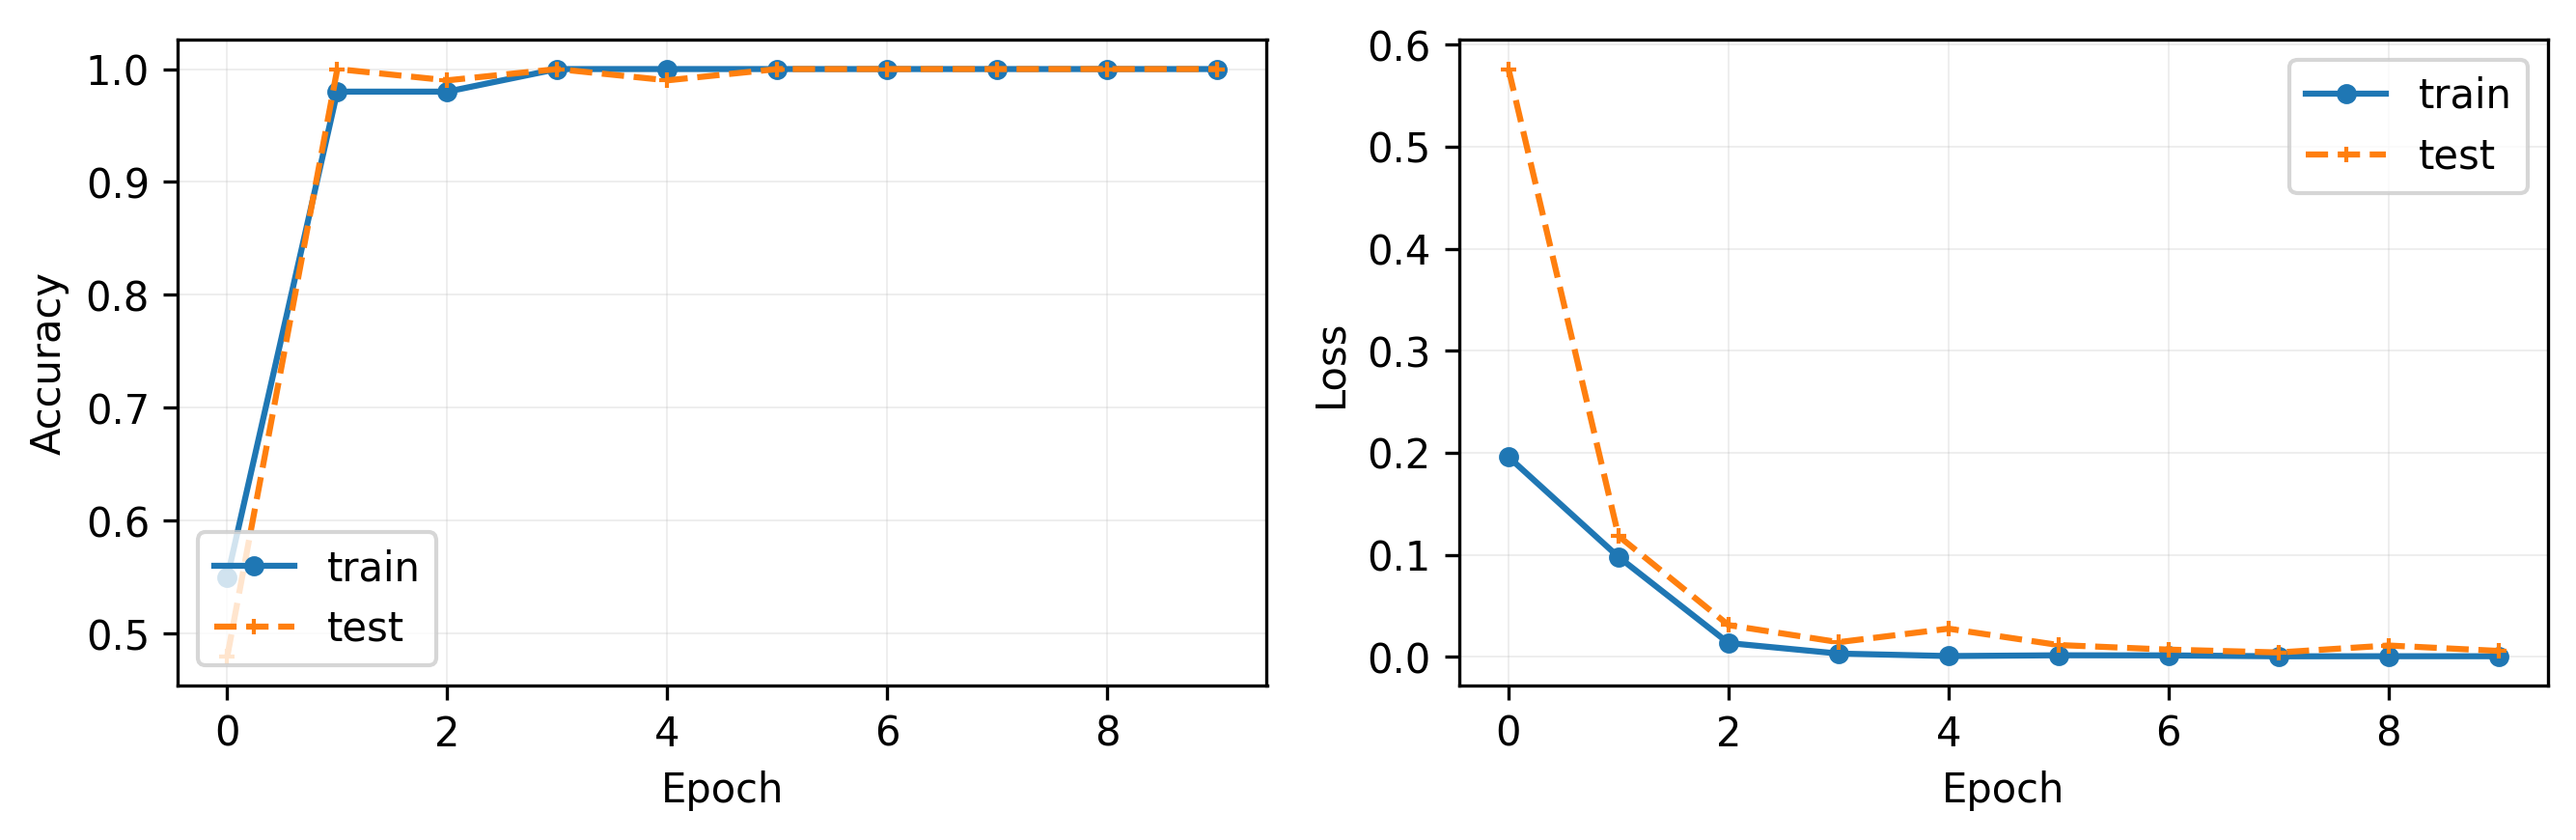

In [32]:
create_acc_loss_graph2(train_Loss,train_ac,test_Loss,test_ac)

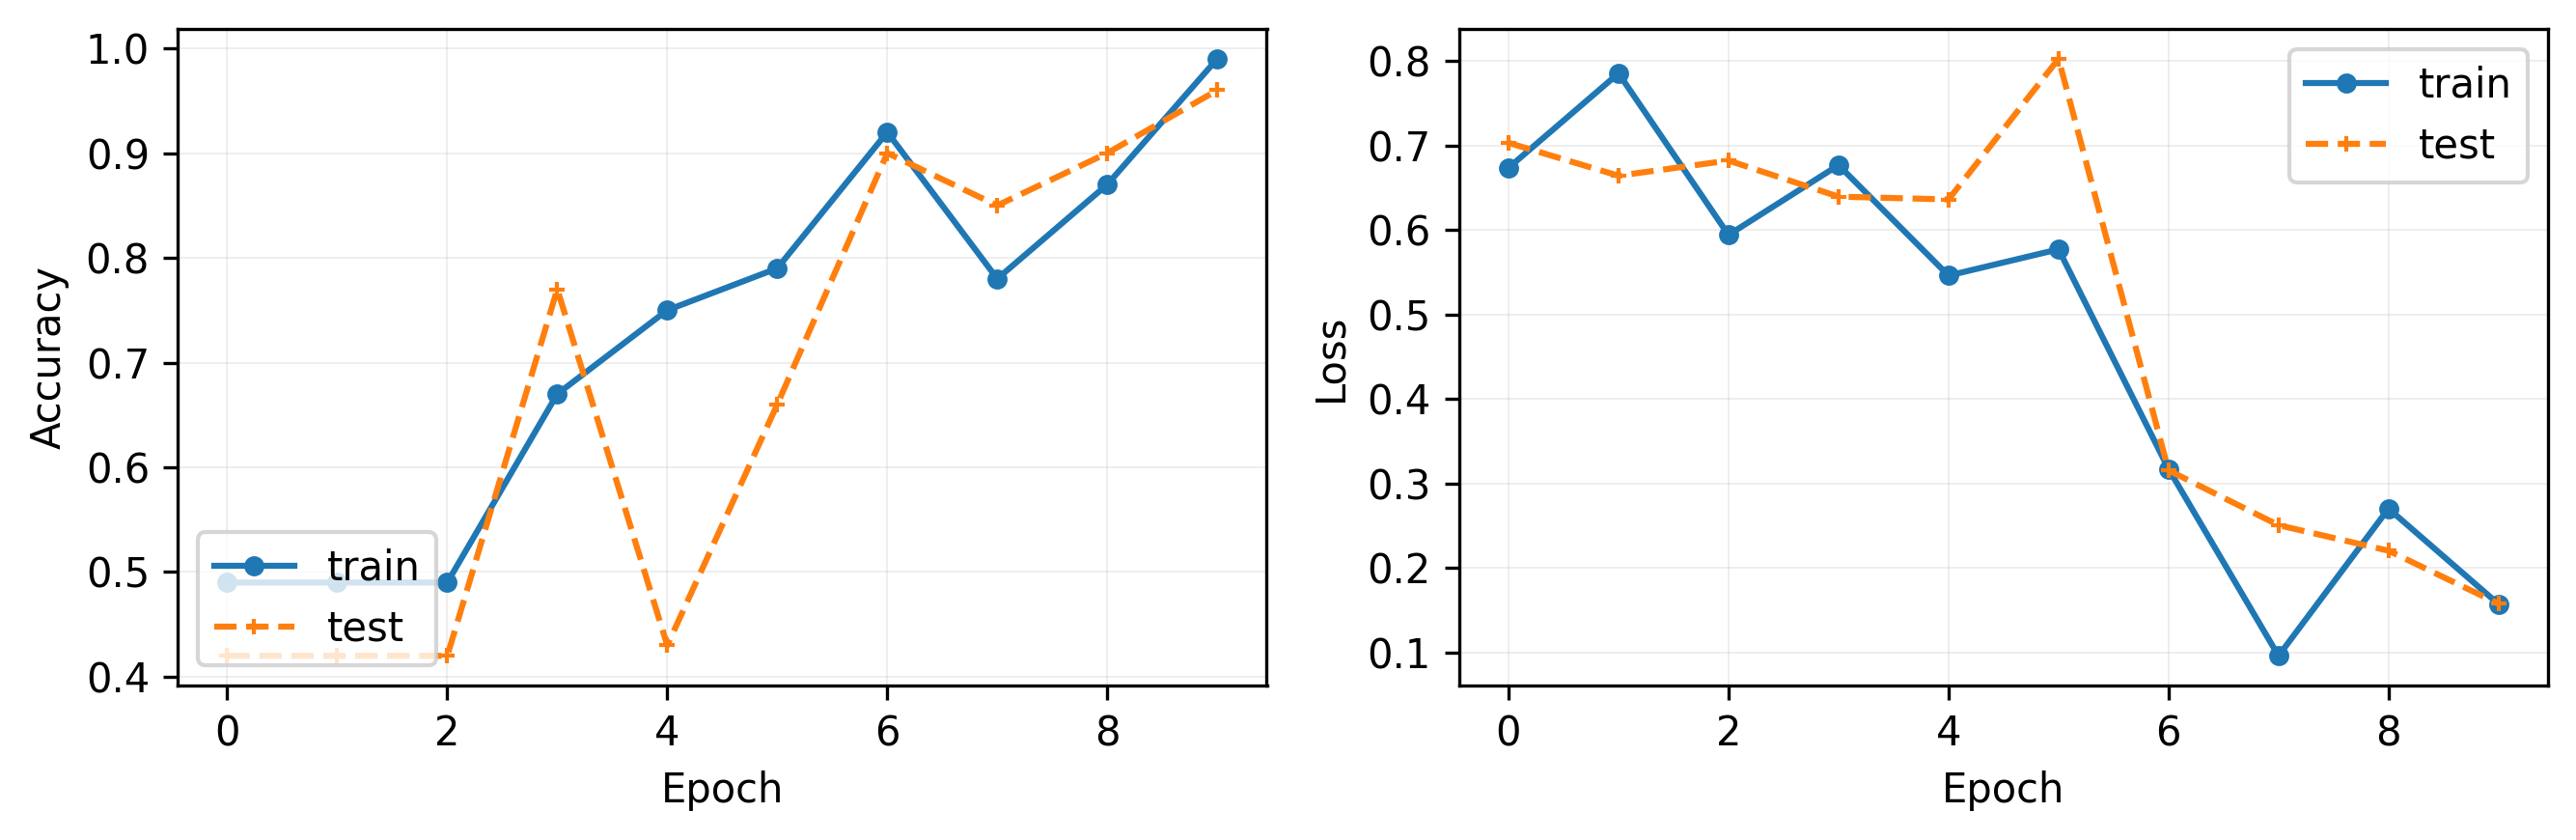

In [14]:
create_acc_loss_graph2(train_Loss,train_ac,test_Loss,test_ac)